In [25]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from quatt_aws_utils.s3 import create_s3_client
from datetime import datetime
from sklearn.model_selection import train_test_split

In [15]:
def preProcessSplitDataFrame(data_df: pd.DataFrame, y_offset=0):

    # Remove Nans
    data_df.dropna(axis=0)

    # Correct circulating pump power values
    data_df['hp1.circulatingPumpDutyCycle'] = data_df['hp1.circulatingPumpDutyCycle']*data_df['hp1.getCirculatingPumpRelay']
    # data_df['calculatedPower'] = data_df['hp1.acInputVoltage']*data_df['hp1.acInputCurrent']
    # data_df['calculatedPowerSquaredCurrent'] = data_df['hp1.acInputVoltage']*(data_df['hp1.acInputCurrent']**2)
    # data_df['calculatedPowerSquareRootCurrent'] = data_df['hp1.acInputVoltage']*(data_df['hp1.acInputCurrent']**0.5)

    # # Add non-linear power terms
    # data_df['powerSquared'] = data_df['qc.hp1PowerInput']**0.5

    # Split the data into input features (X) and target variable (y)
    feature_cols = ['qc.hp1PowerInput', 'hp1.getFanSpeed', 'hp1.bottomPlateHeaterEnable', 'hp1.compressorCrankcaseHeaterEnable']
    # feature_cols = ['calculatedPower', 'calculatedPowerSquaredCurrent', 'calculatedPowerSquareRootCurrent', 'hp1.getFanSpeed', 'hp1.bottomPlateHeaterEnable', 'hp1.compressorCrankcaseHeaterEnable']
    # feature_cols = ['hp1PowerInput', 'getFanSpeed']

    # Split data into train and test
    train, test = train_test_split(data_df, test_size=0.5, shuffle=False)

    X_train = train[feature_cols]
    X_test = test[feature_cols]

    # y = data['PowerIn']
    try:
        y_train = train['system.externalElectricityMeterPower'] + y_offset - train['hp1.circulatingPumpDutyCycle']
        y_test = test['system.externalElectricityMeterPower'] + y_offset - test['hp1.circulatingPumpDutyCycle']
    except KeyError:
        y_train = train['qc.externalElectricityMeterPower'] + y_offset - train['hp1.circulatingPumpDutyCycle']
        y_test = test['qc.externalElectricityMeterPower'] + y_offset - test['hp1.circulatingPumpDutyCycle']

    # if y.isna().any():
    #     idx = y[~y.isna()].index
    #     y = y[y.index.isin(idx)]
    #     X = X[X.index.isin(idx)]

    return X_train, y_train, X_test, y_test

In [16]:
def evaluate_model(model, X_test, y_test):
    # Evaluate the model on the test data using mean squared error (MSE)
    y_pred = model.predict(X_test)

    # Evaluate
    print("rmse = ", np.sqrt(mean_squared_error(y_test, y_pred)))
    # print("mse = ", mean_squared_error(y_train, y_train_pred))
    print("mae = ", mean_absolute_error(y_test, y_pred))

    # Plot the training target against the predicted values
    plt.plot(X_test.index, y_test, X_test.index, y_pred)
    plt.xlabel('Time index')
    plt.ylabel('Measured and predicted values')
    plt.title('Test data: Target vs Predictions')
    plt.legend(['Measured', 'Predicted'])
    plt.show()

In [24]:
quatt_s3_client = create_s3_client(aws_profile="nout_prod")

# Load training data from s3 into a pandas DataFrame
cics = [
        'CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6', 
        'CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c',
        'CIC-7eede49c-42c2-5b41-94aa-481dad189abf',
        'CIC-e265a6ef-8365-5bab-a661-c23935c3c6ea'
        ]
offsets = [
           -11,
           -11,
           0,
           0
           ]
props = [
         {'system': ['externalElectricityMeterPower'],
         'qc': ['hp1PowerInput'],
         'hp1': ['acInputVoltage', 'acInputCurrent', 'getFanSpeed', 'bottomPlateHeaterEnable', 'compressorCrankcaseHeaterEnable', 'circulatingPumpDutyCycle', 'getCirculatingPumpRelay']},
         {'system': ['externalElectricityMeterPower'],
         'qc': ['hp1PowerInput'],
         'hp1': ['acInputVoltage', 'acInputCurrent', 'getFanSpeed', 'bottomPlateHeaterEnable', 'compressorCrankcaseHeaterEnable', 'circulatingPumpDutyCycle', 'getCirculatingPumpRelay']},
         {'qc': ['hp1PowerInput', 'externalElectricityMeterPower'],
         'hp1': ['acInputVoltage', 'acInputCurrent', 'getFanSpeed', 'bottomPlateHeaterEnable', 'compressorCrankcaseHeaterEnable', 'circulatingPumpDutyCycle', 'getCirculatingPumpRelay']},
         {'qc': ['hp1PowerInput', 'externalElectricityMeterPower'],
         'hp1': ['acInputVoltage', 'acInputCurrent', 'getFanSpeed', 'bottomPlateHeaterEnable', 'compressorCrankcaseHeaterEnable', 'circulatingPumpDutyCycle', 'getCirculatingPumpRelay']}
]
start_date = datetime(2023, 4, 1)
end_date = datetime(2023, 4, 4)


for cic, offset, prop in zip(cics, offsets, props):
        extract_df = quatt_s3_client.get_cic_data(cic_ids=cic, 
                                                  start_date=start_date, end_date=end_date, 
                                                  filter_objects=['time'], 
                                                  filter_properties=prop,
                                                  cloud_type='production'
                                                 )
        X_extract_train, y_extract_train, X_extract_test, y_extract_test = preProcessSplitDataFrame(extract_df, offset)
        if 'X_train' in locals():
                X_train = pd.concat([X_train, X_extract_train], ignore_index=True)
                y_train = pd.concat([y_train, y_extract_train], ignore_index=True)
                X_test = pd.concat([X_test, X_extract_test], ignore_index=True)
                y_test = pd.concat([y_test, y_extract_test], ignore_index=True)
        else:
                X_train = X_extract_train
                y_train = y_extract_train
                X_test = X_extract_test
                y_test = y_extract_test


Found credentials in shared credentials file: ~/.aws/credentials

NameError: name 'quatt_s3_client' is not defined

Coefficients =  [1.1207134654021642, -0.050513158852380065, 148.36323492013514, 0.0, 5.001590815860624]
rmse =  16.34565140627084
mae =  6.849218128292328


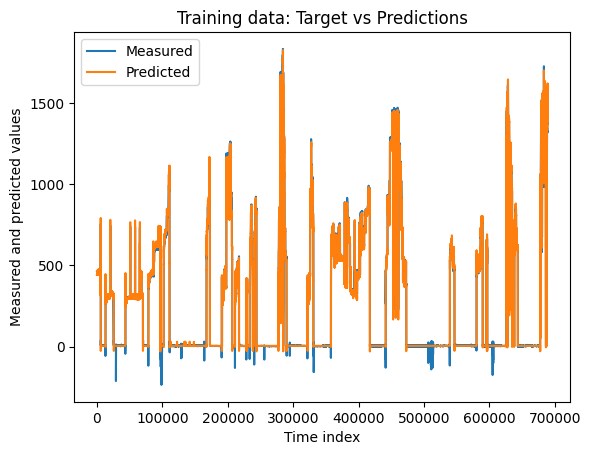

In [5]:
# Create a Lasso model with alpha=0.1 (controls the strength of regularization)
lasso = Lasso(alpha=0.1, fit_intercept=True)

# Train the model on the training data
lasso.fit(X_train, y_train)

# Evaluate
print("Coefficients = ", list(lasso.coef_) + [lasso.intercept_])
y_train_pred = lasso.predict(X_train)
print("rmse = ", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("mae = ", mean_absolute_error(y_train, y_train_pred))

# Plot the training target against the predicted values
plt.plot(X_train.index, y_train, X_train.index, y_train_pred)
plt.xlabel('Time index')
plt.ylabel('Measured and predicted values')
plt.title('Training data: Target vs Predictions')
plt.legend(['Measured', 'Predicted'])
plt.show()

Coefficients =  [1.1190749424102222, -0.049609742086102276, 150.69087091896463, 0.0, 4.9982169337547475]
rmse =  16.33853923303097
mae =  6.854617946214394


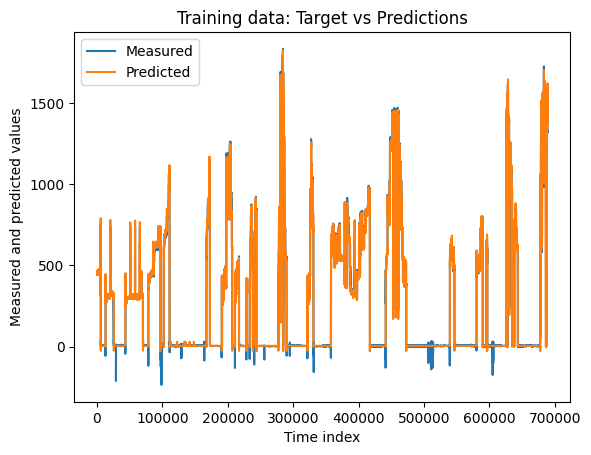

In [6]:
# Create a Linear model
linreg = LinearRegression(fit_intercept=True)

# Train the model on the training data
linreg.fit(X_train, y_train)

# Evaluate
print("Coefficients = ", list(linreg.coef_) + [linreg.intercept_])
y_train_pred = linreg.predict(X_train)
print("rmse = ", np.sqrt(mean_squared_error(y_train, y_train_pred)))
# print("mse = ", mean_squared_error(y_train, y_train_pred))
print("mae = ", mean_absolute_error(y_train, y_train_pred))

# Plot the training target against the predicted values
plt.plot(X_train.index, y_train, X_train.index, y_train_pred)
plt.xlabel('Time index')
plt.ylabel('Measured and predicted values')
plt.title('Training data: Target vs Predictions')
plt.legend(['Measured', 'Predicted'])
plt.show()

rmse =  21.026628836003653
mae =  9.771660568039845


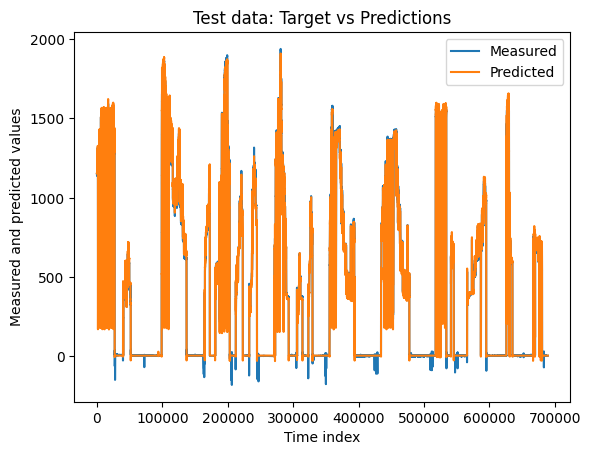

In [7]:
evaluate_model(linreg, X_test=X_test, y_test=y_test)